In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/ddr/ddr.zip'

Streaming output truncated to the last 5000 lines.
  inflating: ddr/train/2/007-2421-100.jpg  
  inflating: ddr/train/2/007-2422-100.jpg  
  inflating: ddr/train/2/007-2424-100.jpg  
  inflating: ddr/train/2/007-2425-100.jpg  
  inflating: ddr/train/2/007-2426-100.jpg  
  inflating: ddr/train/2/007-2428-100.jpg  
  inflating: ddr/train/2/007-2431-100.jpg  
  inflating: ddr/train/2/007-2433-100.jpg  
  inflating: ddr/train/2/007-2436-100.jpg  
  inflating: ddr/train/2/007-2437-100.jpg  
  inflating: ddr/train/2/007-2438-100.jpg  
  inflating: ddr/train/2/007-2439-100.jpg  
  inflating: ddr/train/2/007-2440-100.jpg  
  inflating: ddr/train/2/007-2444-100.jpg  
  inflating: ddr/train/2/007-2446-100.jpg  
  inflating: ddr/train/2/007-2447-100.jpg  
  inflating: ddr/train/2/007-2448-100.jpg  
  inflating: ddr/train/2/007-2449-100.jpg  
  inflating: ddr/train/2/007-2450-100.jpg  
  inflating: ddr/train/2/007-2452-100.jpg  
  inflating: ddr/train/2/007-2453-100.jpg  
  inflating: ddr/train/2/

In [3]:
import keras
from keras import backend as K
import numpy as np
import glob
import shutil
from tensorflow.keras import regularizers
from keras import layers
from sklearn.model_selection import StratifiedKFold
from keras.layers import GlobalAveragePooling2D,Conv2D,Multiply,LayerNormalization,AveragePooling2D,GlobalMaxPool2D,Conv1D,BatchNormalization
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.densenet import DenseNet121
from keras.applications.vgg19 import VGG19
from keras.applications import ResNet50
from keras.layers.core import Lambda
from sklearn.metrics import roc_auc_score
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.layers import Dense,Reshape,Activation,Permute,Dot,Dropout,ReLU,Add
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
# from keras.utils import multi_gpu_model
from matplotlib import pyplot as plt
from keras.models import load_model
import os

In [4]:
def Global_Attention_Block(inputs):
        shape=K.int_shape(inputs)
#         avg_pool=GlobalAveragePooling2D()(inputs)
        avg_pool=AveragePooling2D(pool_size=(shape[1],shape[2])) (inputs)
        avg_pool=Conv2D(shape[3],1,padding='same')(avg_pool)
        avg_pool=Activation('sigmoid')(avg_pool)
        avg_pool=Conv2D(shape[3],1,padding='same')(avg_pool)
        avg_pool=Activation('sigmoid')(avg_pool)
        
        C_A= Multiply()([inputs,avg_pool])
        avg_pool=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))(C_A)
        avg_pool=Activation('sigmoid')(avg_pool)
        S_A= Multiply()([avg_pool,C_A])
        return S_A

In [5]:
def ChannelAttention(inputs,ratio):
    channels = inputs.shape[-1]
    l1=Dense(channels//ratio,activation='relu',use_bias=False)
    l2=Dense(channels,use_bias=False)


    avg_pool = GlobalAveragePooling2D()(inputs)
    avg_pool=l1(avg_pool)
    avg_pool=l2(avg_pool)

    max_pool=GlobalMaxPool2D()(inputs)
    max_pool=l1(max_pool)
    max_pool=l2(max_pool)

    fc2 =max_pool+avg_pool
    fc2 = Activation('sigmoid')(fc2)
    attention = Multiply()([inputs, fc2])
    return attention

In [6]:
def Category_Attention_Block(inputs,classes,k):
    shape=K.int_shape(inputs)
    F_1=Conv2D(k*classes,1,padding='same')(inputs)
    F_1=BatchNormalization()(F_1)
    F1=Activation('sigmoid')(F_1)
    
    F_2=F1
    x=GlobalMaxPool2D()(F_2)
    x=Reshape((classes,k)) (x)
    S=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))(x)
    
    x=Reshape((shape[1],shape[2],classes,k)) (F1)
    x=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))(x)
    x=Multiply()([S,x])
    M=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))(x)
    
    semantic=Multiply()([inputs,M])
    return semantic

In [7]:
def gloablchannelattention(inputs):
  shape=K.int_shape(inputs)
  num_filters=shape[-1]
  
  initial=GlobalAveragePooling2D()(inputs)
  initial=Reshape((1,num_filters))(initial)

  a=Conv1D(num_filters,1,pooling='same')(initial)
  a=Activation('sigmoid')(a)

  b=Conv1D(num_filters,1,pooling='same')(initial)
  b=Activation('sigmoid')(b)

  b=K.permute_dimensions(b,(0,2,1))

  out=K.batch_dot(b,c,axes=(2,1))
  out=Activation('softmax')(out)

  c=Reshape((shape[1]*shape[2],num_filters))(inputs)

  final=K.batch_dot(c,out,axes=(2,1))

  final=Reshape((shape[1],shape[2],shape[3]))(final)

  return final

In [8]:
def SelfAttention(inputs,ratio):
   shape=K.int_shape(inputs)
   num_filters=shape[-1]
  #query
   x_q=Conv2D(shape[-1]//ratio,(1,1),padding='same')(inputs)
   x_q=LayerNormalization()(x_q)
   x_q=Activation('relu')(x_q)
   x_qnew=Reshape((shape[1]*shape[2],shape[3]//ratio))(x_q)

  #key
   x_k=Conv2D(shape[-1]//ratio,(1,1),padding='same')(inputs)
   x_k=LayerNormalization()(x_k)
   x_k=Activation('relu')(x_k)
   x_knew=Reshape((shape[1]*shape[2],shape[3]//ratio))(x_k)
  
   x_knew=K.permute_dimensions(x_knew,(0,2,1))
  #value
   x_v=Conv2D(shape[-1]//ratio,(1,1),padding='same')(inputs)
   x_v=LayerNormalization()(x_v)
   x_v=Activation('relu')(x_v)
   x_vnew=Reshape((shape[1]*shape[2],shape[3]//ratio))(x_v)

   

   x=K.batch_dot(x_qnew, x_knew,axes=(2,1))


   x1=Activation('softmax')(x)
   x2=K.batch_dot(x1, x_vnew,axes=(2,1))

   x_final=Reshape((shape[1],shape[2],shape[3]//ratio))(x2)

   x_final=Conv2D(shape[-1],(1,1),padding='same')(x_final)

   x_final=ReLU()(x_final)

   x_final=Add()([x_final,inputs])

   return x_final




In [ ]:
def rotateToAttend(input_feature):
  shape = K.int_shape(input_feature)
  # HxwxC
  permute_1 =tf.keras.layers.Permute((3,2,1),input_shape=(shape[1],shape[2],shape[3]))(input_feature) 
  #  cxwxh
  x1 = Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))(permute_1)
  x2 = Lambda(lambda x: K.max(x,axis=-1,keepdims=True))(permute_1)
  x3 = tf.keras.layers.Concatenate(axis=-1)([x1, x2])
  x = Conv2D(1,7, padding='same', dilation_rate=(1, 1)) (x3)
  x = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.01)(x)
  x = tf.keras.activations.sigmoid(x)  
  x = tf.keras.layers.Multiply()([x,permute_1])
  F1 = tf.keras.layers.Permute((3,2,1),input_shape=(shape[1],shape[2],shape[3]))(x)

  permute_2 = tf.keras.layers.Permute((1,3,2),input_shape=(shape[1],shape[2],shape[3]))(input_feature)
  x1 = Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))(permute_2)
  x2 = Lambda(lambda x: K.max(x,axis=-1,keepdims=True))(permute_2)
  x3 = tf.keras.layers.Concatenate(axis=-1)([x1, x2])
  x = Conv2D(1,7, padding='same', dilation_rate=(1, 1)) (x3)
  x = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.01)(x)
  x = tf.keras.activations.sigmoid(x)  
  x = tf.keras.layers.Multiply()([x,permute_2])
  F2 = tf.keras.layers.Permute((1,3,2),input_shape=(shape[1],shape[2],shape[3]))(x)


  permute_3 = input_feature
  x1 = Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))(permute_3)
  x2 = Lambda(lambda x: K.max(x,axis=-1,keepdims=True))(permute_3)
  x3 = tf.keras.layers.Concatenate(axis=-1)([x1, x2])
  x = Conv2D(1,7, padding='same', dilation_rate=(1, 1)) (x3)
  x = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.01)(x)
  x = tf.keras.activations.sigmoid(x)  
  F3 = tf.keras.layers.Multiply()([x,permute_3])

  attend_feature = tf.keras.layers.Average()([F1, F2, F3])
  return attend_feature

In [9]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points    

In [10]:
   
def plotmodel(history,name):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1) 
    
    plt.figure(1)                  
    plt.plot(epochs,smooth_curve(acc))
    plt.plot(epochs,smooth_curve(val_acc))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_accuracy'], loc='upper left')
    plt.title(name)
    plt.savefig('acc_'+name+'.png')
    
    plt.figure(2)
    plt.plot(epochs,smooth_curve(loss))
    plt.plot(epochs,smooth_curve(val_loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.title(name)
    plt.savefig('loss_'+name+'.png')

In [11]:
def get_base_model(model_name,img_size):
    if(model_name=='vgg19'):
        base_model=VGG19(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    if model_name =='densenet121':
        base_model=DenseNet121(include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if(model_name=='inceptionv3'):
        base_model=InceptionV3(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    if(model_name=='resnet50'):
        base_model=ResNet50(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    if(model_name=='mobilenet'):
        base_model=MobileNet(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    if(model_name=='mobilenet1.0'):
        base_model=MobileNet(include_top=False,weights='imagenet',alpha=1.0,input_shape=(img_size,img_size,3))
    if(model_name=='xception'):
        base_model=Xception(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))
    return base_model

In [15]:
def train_model(model,image_size,batch_size,save_name,lr1,lr2,Epochs1,Epochs2):
#     dataParam={'messidor': [667,242,2,'./dataset/train','./dataset/test']}
    
#     train_num,valid_num,classes,train_dir,test_dir = dataParam[dataset]


  #  num_folds = 5


#  image_files = glob.glob(train_dir + '/**/*.tif', recursive=True)


#  labels = [img_file.split('/')[-2] for img_file in image_files]


#  class_mapping = {'non-referrable': 0, 'referrable': 1}
#  numeric_labels = [class_mapping[label] for label in labels]

  
#  classes=['non-referrable','referrable']


#  X = np.array(image_files)
#  y = np.array(numeric_labels)
#  skf = StratifiedKFold(n_splits=num_folds, shuffle=True)

#  for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
#     print('Fold:', fold+1)
#     print('Training samples:', len(train_index))
#     print('Validation samples:', len(val_index))
#     train_dir_fold = 'train_fold_{}'.format(fold+1)
#     val_dir_fold = 'val_fold_{}'.format(fold+1)
    
#     os.makedirs(train_dir_fold, exist_ok=True)
#     os.makedirs(val_dir_fold, exist_ok=True)
    
#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
    
#     for class_label in classes:
#         os.makedirs(os.path.join(train_dir_fold, class_label), exist_ok=True)
    
#     for class_label in classes:
#         os.makedirs(os.path.join(val_dir_fold, class_label), exist_ok=True)
    
#     for i in range(len(X_train)):
#         class_label = labels[train_index[i]]
#         shutil.copy2(X_train[i], os.path.join(train_dir_fold, class_label, X_train[i].split('/')[-1]))
        

#     for i in range(len(X_val)):
#         class_label = labels[val_index[i]]
#         shutil.copy2(X_val[i], os.path.join(val_dir_fold, class_label, X_val[i].split('/')[-1]))
    train_dir_fold='/content/ddr/train'
    val_dir_fold='/content/ddr/validation'
    image_size=512
    batch_size=16
    # train_dir = '/content/drive/MyDrive/Messidor/data'
    train_num,valid_num=6260,2503 

    train=ImageDataGenerator(rescale=1./255,horizontal_flip=True,vertical_flip=True,rotation_range=90)     

    valid = ImageDataGenerator(rescale=1./255)
      
    train_data = train.flow_from_directory(train_dir_fold, target_size=(image_size, image_size),shuffle=True,
                                                  batch_size=batch_size)
    val_data = valid.flow_from_directory(val_dir_fold, target_size=(image_size, image_size),shuffle=False,
                                                 batch_size=batch_size)
                                                  
      
    
    
    
    lr_decay=ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1)
    save_model=ModelCheckpoint('new/'+save_name+'{epoch:02d}.h5', monitor='val_loss',save_best_only=True,mode='min')
    
    for layer in base_model.layers:
         layer.trainable=False

    model.compile(optimizer=Adam(learning_rate=lr1,decay=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(train_data,steps_per_epoch=train_num/batch_size,validation_data=val_data,
                        validation_steps=valid_num/batch_size,epochs=Epochs1,workers=2,
                       callbacks=[lr_decay,save_model])
     
    for layer in base_model.layers:
         layer.trainable = True
        
    model.compile(optimizer=Adam(learning_rate=lr2,decay=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])
    history=model.fit(train_data,steps_per_epoch=train_num/batch_size
                        ,validation_data=val_data,validation_steps=valid_num/batch_size,epochs=Epochs2,workers=2,
                       callbacks=[lr_decay,save_model])

    return history

In [16]:
k=5
lr1=0.005
lr2=0.0001
batch_size= 16
image_size=512
classes=5


base_model=MobileNet(include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
base_in=base_model.input
base_out=base_model.output
num_filters=int(base_out.shape[-1])
# compress=Conv2D(num_filters/2,(1,1),padding='same')(base_out)

# x=gloablchannelattention(base_out)
x=rotateToAttend(base_out)
# x=Global_Attention_Block(base_out)
# x=Category_Attention_Block(x,classes,k)

x=GlobalAveragePooling2D()(x)
# x=Dropout(0.2)(x)
out=Dense(classes,activation='softmax')(x)

parallel_model=Model(base_model.input,out)
parallel_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 256, 256, 32  128         ['conv1[0][0]']                  
                                )                                                           

In [17]:
history=train_model(parallel_model,image_size,batch_size,'densenet121',lr1,lr2,1,10)

Found 6260 images belonging to 5 classes.
Found 2503 images belonging to 5 classes.
391/391 [==============================] - 485s 1s/step - loss: 1.1086 - accuracy: 0.6177 - val_loss: 1.0083 - val_accuracy: 0.5881 - lr: 0.0050
Epoch 1/10
391/391 [==============================] - 517s 1s/step - loss: 0.8458 - accuracy: 0.6895 - val_loss: 1.0585 - val_accuracy: 0.5425 - lr: 1.0000e-04
Epoch 2/10
391/391 [==============================] - 487s 1s/step - loss: 0.6473 - accuracy: 0.7581 - val_loss: 1.2392 - val_accuracy: 0.6484 - lr: 1.0000e-04
Epoch 3/10
391/391 [==============================] - 480s 1s/step - loss: 0.5825 - accuracy: 0.7847 - val_loss: 0.6346 - val_accuracy: 0.7887 - lr: 1.0000e-04
Epoch 4/10
391/391 [==============================] - 484s 1s/step - loss: 0.5211 - accuracy: 0.8115 - val_loss: 0.7111 - val_accuracy: 0.7623 - lr: 1.0000e-04
Epoch 5/10
391/391 [==============================] - 480s 1s/step - loss: 0.4985 - accuracy: 0.8145 - val_loss: 0.7385 - val_accur

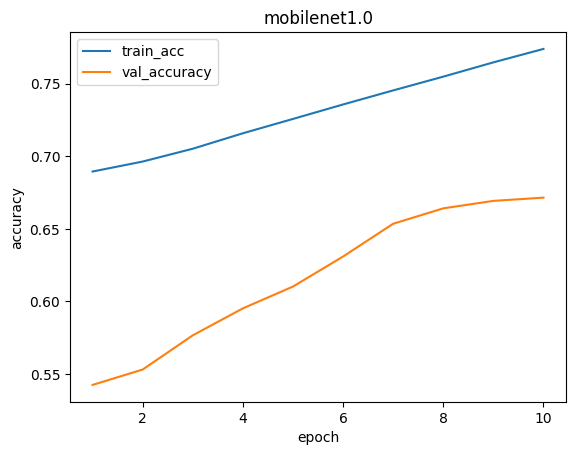

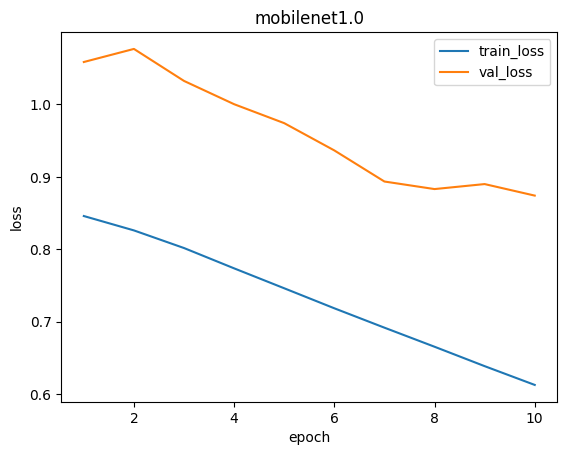

In [18]:
plotmodel(history,'mobilenet1.0')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Model


intermediate_model = Model(inputs=parallel_model.input, outputs=parallel_model.get_layer('add').output)


image_path = '/content/ddr/train/3/007-4382-200.jpg'
target_size = (224, 224)  

img = Image.open(image_path)
img = img.resize(target_size)
img = np.array(img) / 255.0 


img = np.expand_dims(img, axis=0)


attention_map = intermediate_model.predict(img)
print(attention_map.shape) 


attention_map = np.squeeze(attention_map, axis=0)


attention_map = np.mean(attention_map, axis=-1)


attention_map = (attention_map - np.min(attention_map)) / (np.max(attention_map) - np.min(attention_map))


heatmap = plt.imshow(attention_map, cmap='jet')
plt.colorbar(heatmap)


resized_attention_map = np.array(Image.fromarray(attention_map).resize(target_size))


overlay = img[0] + resized_attention_map[..., np.newaxis]
overlay = overlay / np.max(overlay)  


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img[0])
axs[0].axis('off')
axs[0].set_title('Original Image')
axs[1].imshow(overlay)
axs[1].axis('off')
axs[1].set_title('Attention Overlay')
plt.show()


In [20]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/new/densenet12107.h5')

test_dir = 'ddr/test/'  # Path to the test dataset directory
image_size = 512
batch_size = 16

test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    shuffle=False,
    batch_size=batch_size
)

loss, accuracy = model.evaluate(test_data)

print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


Found 3759 images belonging to 5 classes.
235/235 [==============================] - 91s 381ms/step - loss: 0.7886 - accuracy: 0.7382
Test Loss: 0.788621723651886, Test Accuracy: 0.7382282614707947
